In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import math
from matplotlib import pyplot as plt
import sys

sys.path.append('../')

import models
import datasets

device = 'cpu' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [2]:
def k0(phi):
    return (math.pi - phi) / (math.pi)

def k1(phi):
    return (torch.sin(phi) + (math.pi - phi) * torch.cos(phi)) / (math.pi)

def gram_ntk(X, Y):
    """
    Compute the gram matrix of the analytical NTK of a one-hidden-layer infinite-width FCN.
    :param X: torch.tensor of shape (n, d)
    :param Y: torch.tensor of shape (n, d)
    """
    assert Y.size(1) == X.size(1), "data have different dimension!"

    XdY = (X/X.norm(dim=1, keepdim=True)) @ (Y/Y.norm(dim=1,keepdim=True)).t()  #normalize
    XnYn = X.norm(dim=1, keepdim=True) @ Y.norm(dim=1, keepdim=True).t()
    arg = torch.clamp(XdY / XnYn, min=-1.0, max=1.0)
    phi = torch.arccos(arg)
    gram = (XdY * k0(phi) + XnYn * k1(phi)) / (2.0 * X.size(1))

    return gram

def kernel_regression(K_trtr, K_tetr, y_tr, y_te, ridge):
    """
    Perform kernel ridge regression
    :param K_trtr: train-train gram matrix
    :param K_tetr: test-train gram matrix
    :param y_tr: training labels
    :param y_te: testing labels
    :param ridge: ridge value
    :return: mean square error.
    """
    alpha = torch.linalg.solve(
        K_trtr + ridge * torch.eye(y_tr.size(0), device=K_trtr.device),
        y_tr
    )

    f = K_tetr @ alpha
    mse = (f - y_te).pow(2).mean()
    return mse

In [3]:
k0(0),k1(torch.tensor([0]))

(1.0, tensor([1.]))

In [4]:
Mds = [[2,4],[2,5],[3,5],[4,6],[3,6]]

ridge = 0.5

seed_function = [[1,2,3,4,5,6],[7,8,9,10,11,12],[13,14,15,16,17,18],[19,20,21,22,23,24],[25,26,27,28,29,30]]
seed_sample = [[11,22,33,44,55,66],[77,88,99,1010,1111,1212],[1313,1414,1515,1616,1717,1818],[1919,2020,2121,2222,2323,2424],[2525,2626,2727,2828,2929,3030]]

P = [1,8,16,32,64,128, 256, 512, 1024, 2048, 4096,16000,32000]
test_size = 10000

num_average = 6

mses = np.zeros(shape=[len(Mds),len(P)])

max_mse = np.zeros(shape=[len(Mds),len(P)])

min_mse = np.zeros(shape=[len(Mds),len(P)])

for i,md in enumerate(Mds):
    flat_len = (md[0]+1)*(md[1]+1)
    mse = np.zeros(len(P))
    for k in range(num_average):
        print('Dimensions: ',str(md[0]),'\t','Samples: ',str(md[1]),'\t','Seed: ',str(k))
        for j,p in enumerate(P):
            title = 'XY model'
            dataset = datasets.LinearModelxy(
                train_size = p,
                num_samples = md[1],
                dimension = md[0],
                seed_function=seed_function[i][k],
                seed_sample=seed_sample[i][k],
                test_size=test_size,
                transform=None
            )
            
            dataset.samples, dataset.labels = dataset.samples.to(device), dataset.labels.to(device)
        
            ones_tr = torch.ones(p).to(device)
            ones_te = torch.ones(test_size).to(device)
            
            X_tr = dataset.samples[:p].view(p,flat_len)
            y_tr = dataset.labels[:p]
        
            X_tr = torch.cat((X_tr,ones_tr.unsqueeze(1)),1)
            
            X_te = dataset.samples[p:].view(test_size,flat_len)
            y_te = dataset.labels[p:]
        
            X_te = torch.cat((X_te,ones_te.unsqueeze(1)),1)
            
            K_trtr = gram_ntk(X_tr,X_tr)
            K_tetr = gram_ntk(X_te,X_tr)

            mse[j] = kernel_regression(K_trtr, K_tetr, y_tr, y_te, ridge)

            if mse[j] > max_mse[i,j]:
                max_mse[i,j] = mse[j]
            if mse[j] < min_mse[i,j] or min_mse[i,j] == 0:
                min_mse[i,j] = mse[j]
            
            mses[i,j] += mse[j]/num_average

            
            

Dimensions:  2 	 Samples:  4 	 Seed:  0
Dimensions:  2 	 Samples:  4 	 Seed:  1
Dimensions:  2 	 Samples:  4 	 Seed:  2
Dimensions:  2 	 Samples:  4 	 Seed:  3
Dimensions:  2 	 Samples:  4 	 Seed:  4
Dimensions:  2 	 Samples:  4 	 Seed:  5
Dimensions:  2 	 Samples:  5 	 Seed:  0
Dimensions:  2 	 Samples:  5 	 Seed:  1
Dimensions:  2 	 Samples:  5 	 Seed:  2
Dimensions:  2 	 Samples:  5 	 Seed:  3
Dimensions:  2 	 Samples:  5 	 Seed:  4
Dimensions:  2 	 Samples:  5 	 Seed:  5
Dimensions:  3 	 Samples:  5 	 Seed:  0
Dimensions:  3 	 Samples:  5 	 Seed:  1
Dimensions:  3 	 Samples:  5 	 Seed:  2
Dimensions:  3 	 Samples:  5 	 Seed:  3
Dimensions:  3 	 Samples:  5 	 Seed:  4
Dimensions:  3 	 Samples:  5 	 Seed:  5
Dimensions:  4 	 Samples:  6 	 Seed:  0
Dimensions:  4 	 Samples:  6 	 Seed:  1
Dimensions:  4 	 Samples:  6 	 Seed:  2
Dimensions:  4 	 Samples:  6 	 Seed:  3
Dimensions:  4 	 Samples:  6 	 Seed:  4
Dimensions:  4 	 Samples:  6 	 Seed:  5
Dimensions:  3 	 Samples:  6 	 Seed:  0


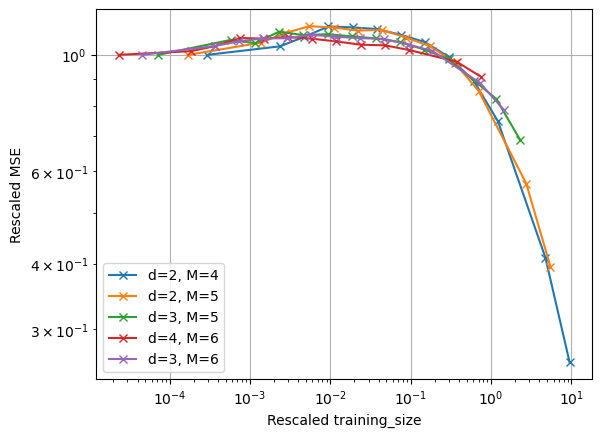

In [7]:
mses = torch.load('mses.pt')

Mds = [[2,4],[2,5],[3,5],[4,6],[3,6]]
ridge = 0.5
P = [1,8,16,32,64,128, 256, 512, 1024, 2048, 4096,16000,32000]

Mds = np.array(Mds)
Md = (Mds[:,0]+1)*(Mds[:,1]+1)
x_scale = Md**3
y_scale = mses[:,0]
#y_scale = (Mds[:,0]+Mds[:,1]+3)/Md**2

torch.save(mses,'mses.pt')

plt.figure()
plt.subplot()
for i,md in enumerate(Mds):
    plt.plot(P/x_scale[i],mses[i,:]/y_scale[i],'x-',label='d='+str(md[0])+', M='+str(md[1]))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Rescaled training_size')
plt.ylabel('Rescaled MSE')
plt.grid('on')
plt.legend()
plt.savefig('fig_KR', bbox_inches='tight')

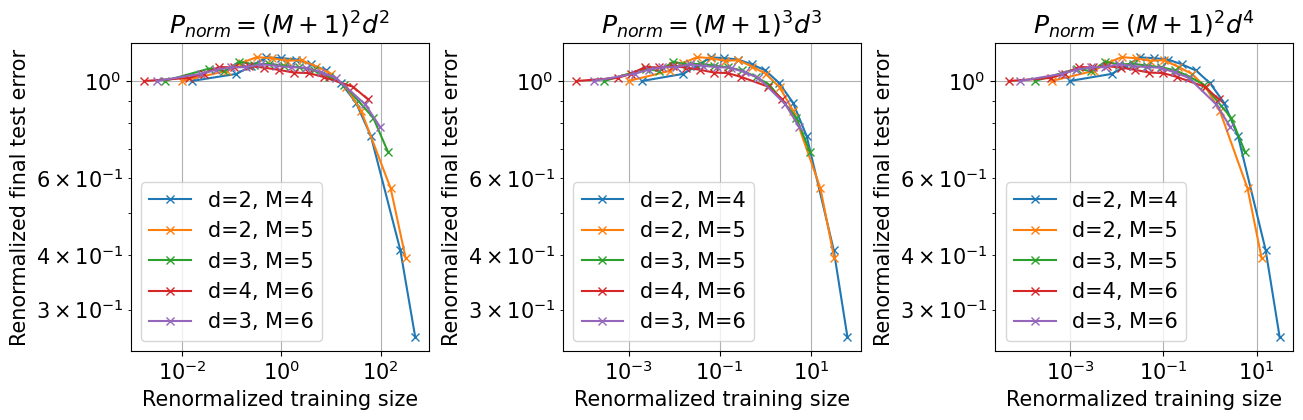

In [58]:
torch.save(mses,'mses_r05.pt')
mses = torch.load('mses.pt')

Mds = [[2,4],[2,5],[3,5],[4,6],[3,6]]
P = [1,8,16,32,64,128, 256, 512, 1024, 2048, 4096,16000,32000]

Mds = np.array(Mds)
Md = (Mds[:,0])*(Mds[:,1]+1)
x_scale_1 = pow(Mds[:,0],2)*pow(Mds[:,1],2)
x_scale_2 = pow(Mds[:,0],3)*pow(Mds[:,1],3)
x_scale_3 = pow(Mds[:,0],2)*pow(Mds[:,1],4)
y_scale = mses[:,0]#(Mds[:,0]+Mds[:,1]+2)/(Md)

plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots( 1, 3, figsize=(15,4))
plt.subplots_adjust(wspace=0.45)
for i,md in enumerate(Mds):
    ax[0].plot(P/x_scale_1[i],mses[i,:]/y_scale[i],'x-',label='d='+str(md[0])+', M='+str(md[1]))
for i,md in enumerate(Mds):
    ax[1].plot(P/x_scale_2[i],mses[i,:]/y_scale[i],'x-',label='d='+str(md[0])+', M='+str(md[1]))
for i,md in enumerate(Mds):
    ax[2].plot(P/x_scale_3[i],mses[i,:]/y_scale[i],'x-',label='d='+str(md[0])+', M='+str(md[1]))   
for j in range(3):
    ax[j].set_yscale('log')
    ax[j].set_xscale('log')
    ax[j].set_xlabel('Renormalized training size')
    ax[j].set_ylabel('Renormalized final test error')
    ax[j].grid('on')
    ax[j].legend()
ax[0].set_title("$P_{norm} = (M+1)^2d^2$")
ax[1].set_title("$P_{norm} = (M+1)^3d^3$")
ax[2].set_title("$P_{norm} = (M+1)^2d^4$")
fig.savefig('fig_KR', bbox_inches='tight')